### Get the transmission curves from https://cosmos.astro.caltech.edu/page/filterset.

I downloaded transmission curves for 32 bands. They are at `/scratch/gpfs/jiaxuanl/Data/popsed/filters`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
# popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

In [3]:
from sedpy import observate

In [26]:
cosmos_filter_list = ['galex_NUV', 'cfht_u', 'B', 'V', 'r', 'ip', 'zpp']
cosmos_filter_list += ['IA' + str(num) for num in [427, 464, 484, 505, 527, 574, 624, 679, 709, 738, 767, 827]]
cosmos_filter_list += ['NB' + str(num) for num in [711, 816]]
cosmos_filter_list += ['hsc_Y', 'Y_uv', 'J_uv', 'H_uv', 'K_uv']
cosmos_filter_list += ['wircam_Ks', 'wircam_H']
cosmos_filter_list += [f'irac_ch{i}' for i in range(1, 5)]

In [5]:
len(cosmos_filter_list)

18

In [5]:
filt_list = observate.load_filters(cosmos_filter_list, 
                                   directory="/scratch/gpfs/jiaxuanl/Data/popsed/filters/")

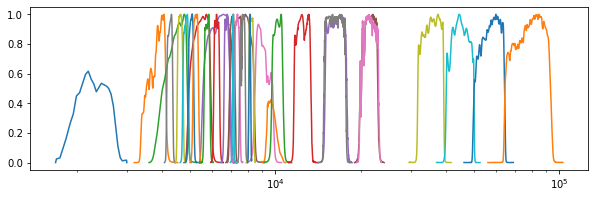

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
for filt in filt_list:
    filt.display(ax=ax)
    
plt.xscale('log')

In [6]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = cosmos_filter_list
speculator._calc_transmission(filters, filter_dir="/scratch/gpfs/jiaxuanl/Data/popsed/filters/")

noise = None
noise_model_dir = './noise_model/nsa_noise_model_mag_chang.npy'

In [7]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0.01, 2])
_prior_NDE[-1] = np.array([7.5, 12.5])

In [8]:
torch.cuda.empty_cache()

In [9]:
pred_mags = {}
for i in range(2):
    pretrain_sample = np.vstack(
        [np.random.uniform(*b, size=(3000)) for b in _prior_NDE]
    ).T

    pretrain_sample = torch.Tensor(pretrain_sample).float()
    pred_mags[i] = speculator._predict_mag_with_mass_redshift_batch(
        pretrain_sample,
        filterset=filters, noise=None)

In [10]:
pred_mags

{0: tensor([[42.6322, 43.7106, 43.9703,  ..., 23.8999, 24.3895, 34.1234],
         [31.1661, 31.1972, 30.8741,  ..., 25.8241, 26.6504, 36.3119],
         [42.6322, 43.7239, 36.5126,  ..., 23.0853, 23.8913, 33.5838],
         ...,
         [36.2552, 28.9135, 27.0537,  ..., 21.4718, 22.3655, 32.0620],
         [37.7509, 35.8683, 35.3522,  ..., 30.2523, 30.7560, 40.3796],
         [24.5206, 23.8298, 23.4933,  ..., 20.6905, 20.8944, 30.7384]],
        grad_fn=<CopySlices>),
 1: tensor([[46.7902, 35.1426, 33.2596,  ..., 20.0584, 20.6780, 30.3786],
         [25.9518, 18.9455, 16.9056,  ..., 11.9212, 12.3162, 21.7349],
         [37.5000, 46.5412, 44.3918,  ..., 28.5498, 28.9902, 38.5627],
         ...,
         [23.4632, 22.7101, 22.6184,  ..., 19.7180, 20.0490, 29.5055],
         [29.5404, 26.1399, 24.9343,  ..., 18.4429, 19.4266, 29.0375],
         [25.8622, 23.5098, 22.4867,  ..., 22.0364, 22.1716, 31.4995]],
        grad_fn=<CopySlices>)}

In [11]:
from geomloss import SamplesLoss

In [12]:
L = SamplesLoss(p=1, blur=0.1, scaling=0.5)

In [13]:
%%time
L(pred_mags[0], pred_mags[1])

CPU times: user 3.91 s, sys: 1.6 s, total: 5.51 s
Wall time: 5.51 s


tensor(2.7649, grad_fn=<SelectBackward0>)

In [14]:
### Clean COSMOS15 data

In [3]:
from astropy.table import Table
# flag = (cosmos_cat['PHOTOZ'] > 0) & (cosmos_cat['PHOTOZ'] < 9.9)

In [4]:
cosmos_cat = Table.read('./reference_catalog/COSMOS2015_cleaned.fits')

In [5]:
np.sum(cosmos_cat['ZMINCHI2'] < 0.5)

96818

In [7]:
cosmos_cat[cosmos_cat['ZMINCHI2'] < 0.5].write('./reference_catalog/COSMOS15_z_0p5.fits')

In [27]:
cosmos_filter_list

['galex_NUV',
 'cfht_u',
 'B',
 'V',
 'r',
 'ip',
 'zpp',
 'IA427',
 'IA464',
 'IA484',
 'IA505',
 'IA527',
 'IA574',
 'IA624',
 'IA679',
 'IA709',
 'IA738',
 'IA767',
 'IA827',
 'NB711',
 'NB816',
 'hsc_Y',
 'Y_uv',
 'J_uv',
 'H_uv',
 'K_uv',
 'wircam_Ks',
 'wircam_H',
 'irac_ch1',
 'irac_ch2',
 'irac_ch3',
 'irac_ch4']

In [76]:
mag_cols = ['MAG_GALEX_NUV', ]
mag_cols += [f'{filt}_MAG_AUTO' for filt in list('uBVr') + ['ip', 'zpp']]
temp = list(zip(list('BBABABAABAAB'), [427, 464, 484, 505, 527, 574, 624, 679, 709, 738, 767, 827]))
mag_cols += ['I' + b[0] + str(b[1]) + '_MAG_AUTO' for b in temp]
mag_cols += [f'{filt}_MAG_AUTO' for filt in ['NB711', 'NB816', 'yHSC', 'Y', 'J', 'H', 'Ks', 'Ksw', 'Hw']]
mag_cols += [f'SPLASH_{num}_MAG' for num in list('1234')]

In [81]:
for i in range(32):
    print(cosmos_filter_list[i], '==', mag_cols[i])

galex_NUV == MAG_GALEX_NUV
cfht_u == u_MAG_AUTO
B == B_MAG_AUTO
V == V_MAG_AUTO
r == r_MAG_AUTO
ip == ip_MAG_AUTO
zpp == zpp_MAG_AUTO
IA427 == IB427_MAG_AUTO
IA464 == IB464_MAG_AUTO
IA484 == IA484_MAG_AUTO
IA505 == IB505_MAG_AUTO
IA527 == IA527_MAG_AUTO
IA574 == IB574_MAG_AUTO
IA624 == IA624_MAG_AUTO
IA679 == IA679_MAG_AUTO
IA709 == IB709_MAG_AUTO
IA738 == IA738_MAG_AUTO
IA767 == IA767_MAG_AUTO
IA827 == IB827_MAG_AUTO
NB711 == NB711_MAG_AUTO
NB816 == NB816_MAG_AUTO
hsc_Y == yHSC_MAG_AUTO
Y_uv == Y_MAG_AUTO
J_uv == J_MAG_AUTO
H_uv == H_MAG_AUTO
K_uv == Ks_MAG_AUTO
wircam_Ks == Ksw_MAG_AUTO
wircam_H == Hw_MAG_AUTO
irac_ch1 == SPLASH_1_MAG
irac_ch2 == SPLASH_2_MAG
irac_ch3 == SPLASH_3_MAG
irac_ch4 == SPLASH_4_MAG


CFHT: u
SuprimeCam: B V r ip zpp IB427 IB464 IA484 IB505 IA527 IB574 IA624 IA679 IA738 IA767 IB709 IB827 NB711 NB816 
Hyper Suprime-Cam: yHSC (Y band)
UltraVISTA-DR2: Y,J,H,Ks
WIRCam: Hw (H),Ksw (Ks)]

In [75]:
[key for key in cosmos_cat.colnames if "SPLASH" in key]

['SPLASH_1_FLUX',
 'SPLASH_1_FLUX_ERR',
 'SPLASH_1_MAG',
 'SPLASH_1_MAGERR',
 'SPLASH_2_FLUX',
 'SPLASH_2_FLUX_ERR',
 'SPLASH_2_MAG',
 'SPLASH_2_MAGERR',
 'SPLASH_3_FLUX',
 'SPLASH_3_FLUX_ERR',
 'SPLASH_3_MAG',
 'SPLASH_3_MAGERR',
 'SPLASH_4_FLUX',
 'SPLASH_4_FLUX_ERR',
 'SPLASH_4_MAG',
 'SPLASH_4_MAGERR']

----